In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import RandomSearch, HyperParameters, Objective

In [2]:
train_df = pd.read_csv('train.csv')

print(train_df.shape)
train_df.head(48)

(7111, 12)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
5,2010-03-10 23:00:00,11.2,56.8,0.7848,1220.9,697.5,1417.2,1462.6,949.0,1.2,4.4,88.1
6,2010-03-11 00:00:00,10.7,55.7,0.7603,1244.2,669.3,1491.2,1413.0,769.6,1.2,3.7,59.5
7,2010-03-11 01:00:00,10.3,57.0,0.7702,1181.4,631.7,1511.1,1359.7,715.4,1.0,3.4,63.9
8,2010-03-11 02:00:00,10.1,62.7,0.7648,1159.6,602.9,1610.6,1212.2,657.2,0.9,2.2,46.4
9,2010-03-11 03:00:00,10.5,59.6,0.7517,1030.2,521.7,1790.2,1148.6,491.0,0.6,1.6,43.0


# EDA

## Target Variables

In [3]:
targets = train_df.columns[-3:]
targets

Index(['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'], dtype='object')

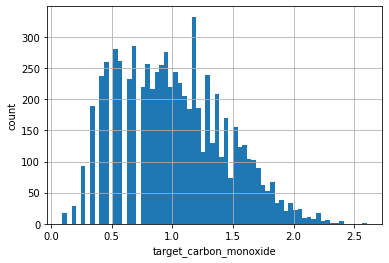

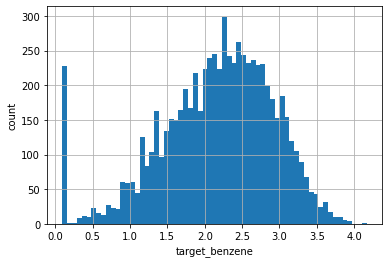

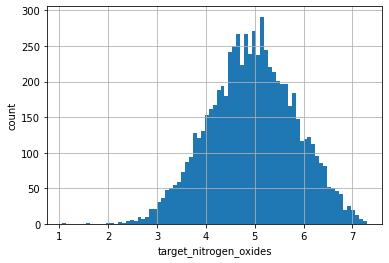

In [4]:
for feature in targets:
    data = train_df.copy()
    
    iqr = stats.iqr(data[feature], interpolation = 'midpoint')
    h = (2 * iqr) / (len(data[feature]) ** (1/3))
    bins = round((max(data[feature]) - min(data[feature])) / h)
    
    data[feature] = np.log1p(data[feature])
    #data[feature] = data[feature] ** 0.5
    
    data[feature].hist(bins = bins)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

In [5]:
train_data = train_df.copy()

## Timestamp data

In [6]:
date_time = np.array(train_data['date_time']).astype(str)

for i in range(len(date_time)):
    date_time[i] = np.where(date_time[i][-8] == '0', date_time[i][-7], date_time[i][-8:-6])

date_time = (date_time).astype(int)

In [7]:
train_data['hour'] = date_time
train_data.drop(['date_time'], axis = 1, inplace = True)

In [8]:
time_dict = {}


for target in targets:
    time_dict[target] = {}
    for i in range(0, 24):
        time_dict[target][i] = []   

In [9]:
hours = np.sort(train_data['hour'].unique())
print(hours)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [10]:
for target in targets:
    for hour in hours:
        time_dict[target][hour].append(train_data.loc[train_data['hour'] == hour][target])
        time_dict[target][hour] = np.median(time_dict[target][hour])

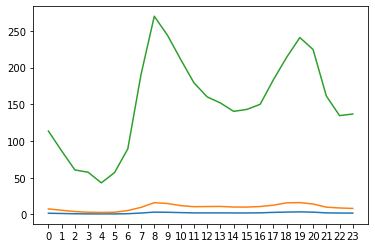

In [11]:
target = []

for target in targets:
    target_vals = []
    for hour in hours:
        target_vals.append(time_dict[target][hour])
    #print(target_vals)
    plt.plot(hours, target_vals)
    plt.xticks(hours)

([<matplotlib.axis.XTick at 0x263c51ae4c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

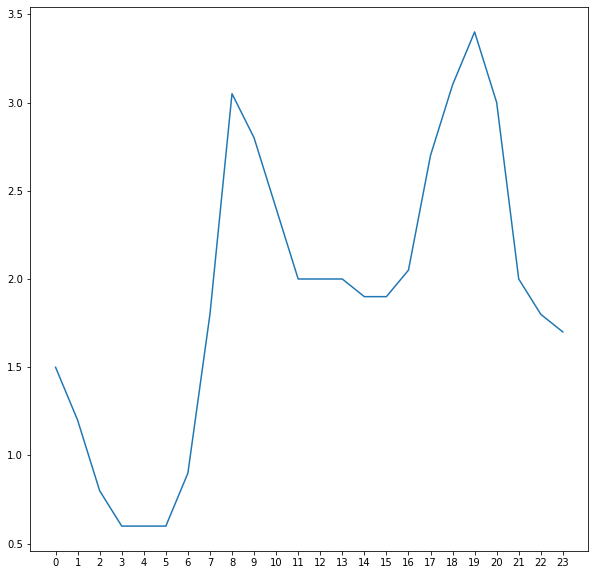

In [12]:
target_1 = []
for hour in hours:
    target_1.append(time_dict[targets[0]][hour])
    #print(target_vals)
plt.figure(figsize = (10, 10))
plt.plot(hours, target_1)
plt.xticks(hours)

([<matplotlib.axis.XTick at 0x263c5207250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

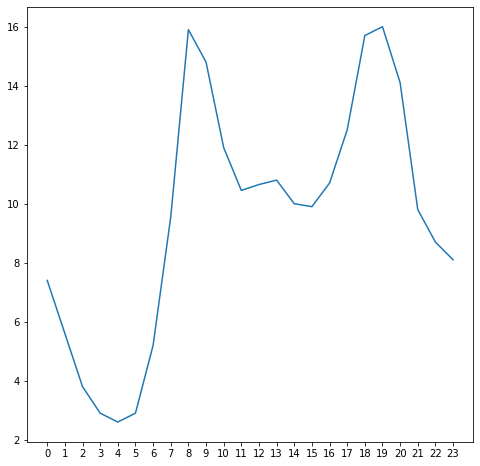

In [13]:
target_2 = []
for hour in hours:
    target_2.append(time_dict[targets[1]][hour])
    #print(target_vals)
plt.figure(figsize = (8, 8))    
plt.plot(hours, target_2)
plt.xticks(hours)

([<matplotlib.axis.XTick at 0x263c557b790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

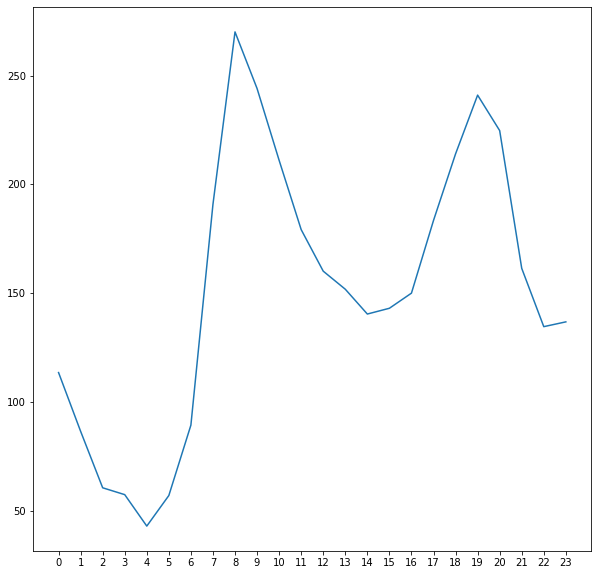

In [14]:
target_3 = []
for hour in hours:
    target_3.append(time_dict[targets[2]][hour])
    #print(target_vals)
plt.figure(figsize = (10, 10))    
plt.plot(hours, target_3)
plt.xticks(hours)

In [15]:
train_data['cat1'] = np.where(train_data['hour'].isin(np.arange(5, 9)), 1, 0)
train_data['cat2'] = np.where(train_data['hour'].isin(np.arange(9, 16)), 1, 0)
train_data['cat3'] = np.where(train_data['hour'].isin(np.arange(16, 20)), 1, 0)
train_data['cat4'] = np.where(train_data['hour'].isin([20, 21, 22, 23, 0, 1, 2, 3, 4]), 1, 0)

In [16]:
train_data.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,hour,cat1,cat2,cat3,cat4
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,18,0,0,1,0
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,19,0,0,1,0
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,20,0,0,0,1
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,21,0,0,0,1
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,22,0,0,0,1


In [17]:
train_data.drop('hour', axis = 1, inplace = True)

## Missing Values

In [18]:
train_data.isnull().sum()

deg_C                     0
relative_humidity         0
absolute_humidity         0
sensor_1                  0
sensor_2                  0
sensor_3                  0
sensor_4                  0
sensor_5                  0
target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
cat1                      0
cat2                      0
cat3                      0
cat4                      0
dtype: int64

## Numerical Features

In [19]:
num_features = [feature for feature in train_data.columns[:-4] if feature not in targets]

train_data[num_features].head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2


### Distribution

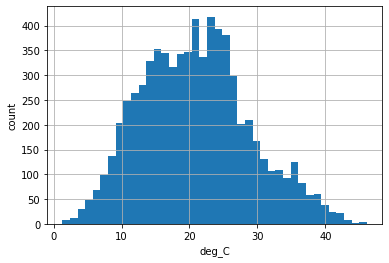

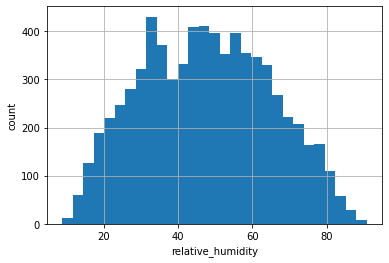

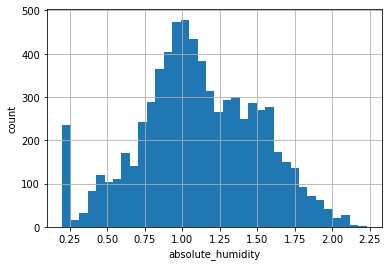

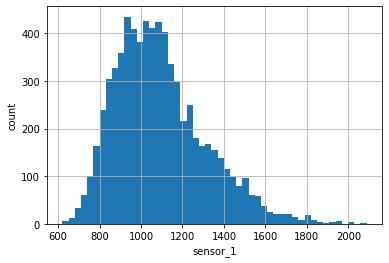

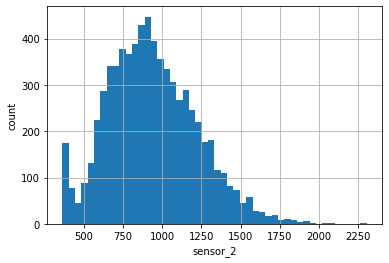

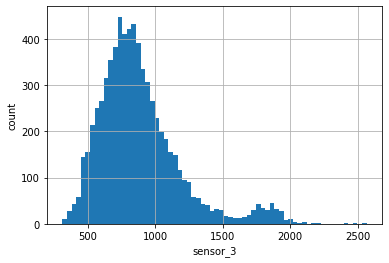

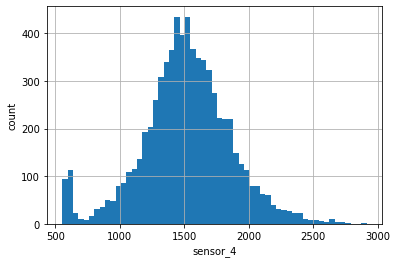

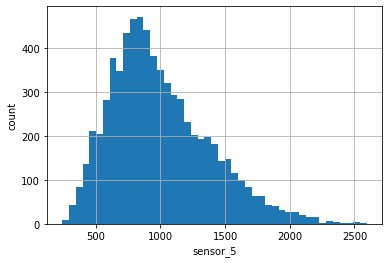

In [20]:
for feature in num_features:
    iqr = stats.iqr(train_data[feature], interpolation = 'midpoint')
    h = (2 * iqr) / (len(train_data[feature]) ** (1/3))
    bins = round((max(train_data[feature]) - min(train_data[feature])) / h)
    
    train_data[feature].hist(bins = bins)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

In [21]:
right_skewed = ['sensor_1', 'sensor_2', 'sensor_3']

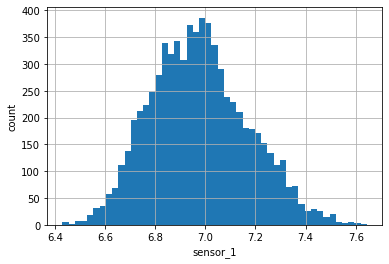

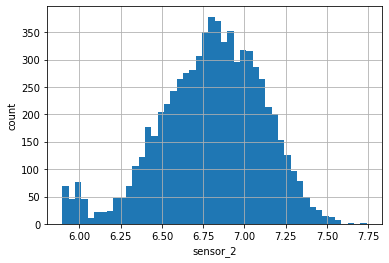

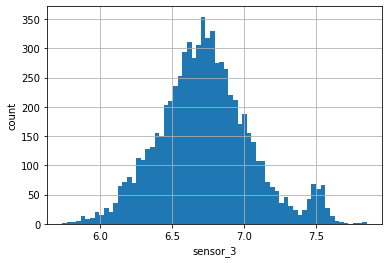

In [22]:
for feature in right_skewed:
    iqr = stats.iqr(train_data[feature], interpolation = 'midpoint')
    h = (2 * iqr) / (len(train_data[feature]) ** (1/3))
    bins = round((max(train_data[feature]) - min(train_data[feature])) / h)
    
    train_data[feature] = np.log(train_data[feature])
    #data[feature] = data[feature] ** 0.5
    
    train_data[feature].hist(bins = bins)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

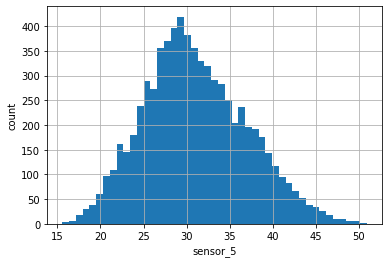

In [23]:
feature = 'sensor_5'

iqr = stats.iqr(train_data[feature], interpolation = 'midpoint')
h = (2 * iqr) / (len(train_data[feature]) ** (1/3))
bins = round((max(train_data[feature]) - min(train_data[feature])) / h)
    
train_data[feature] = train_data[feature] ** 0.5
    
train_data[feature].hist(bins = bins)
plt.xlabel(feature)
plt.ylabel('count')
plt.show()

## vs Target Variable

In [24]:
for target in targets:
    train_data[target] = np.log1p(train_data[target])

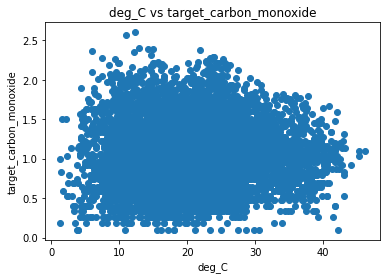

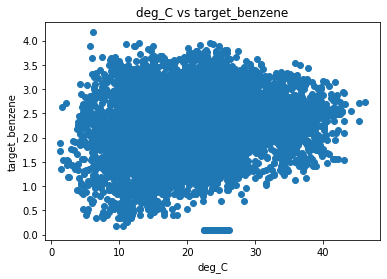

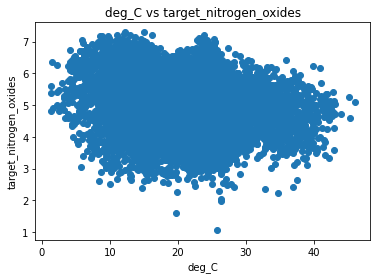

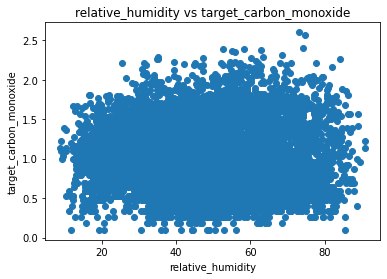

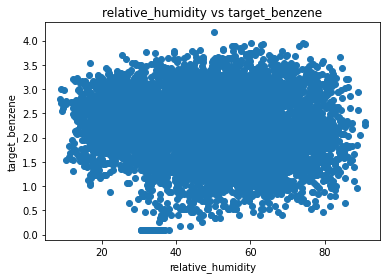

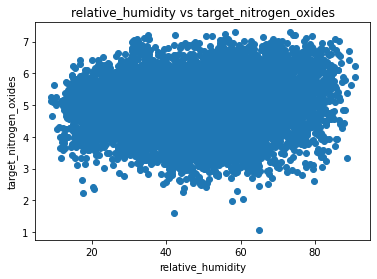

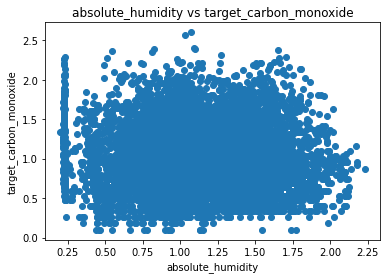

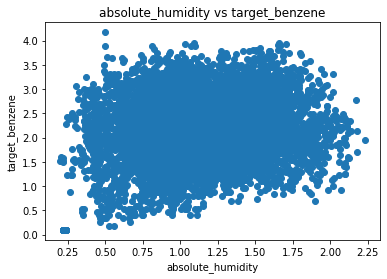

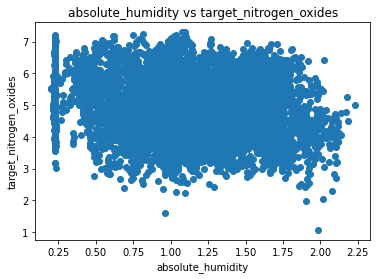

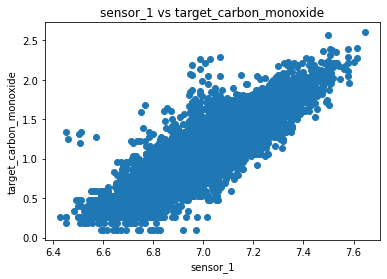

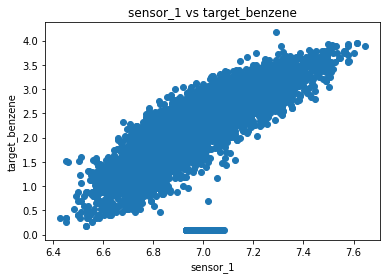

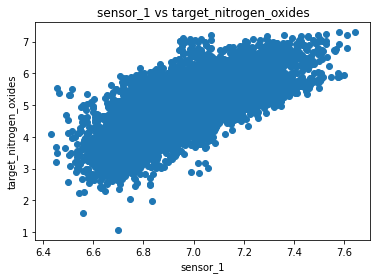

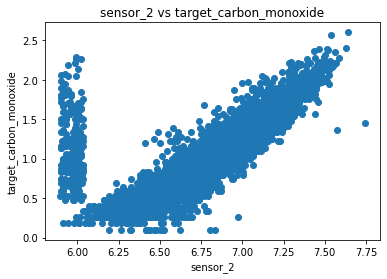

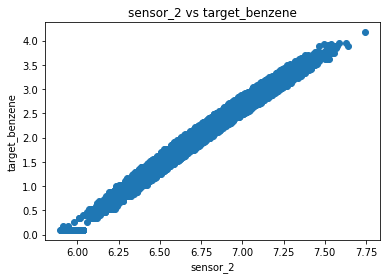

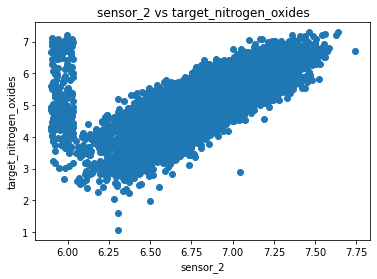

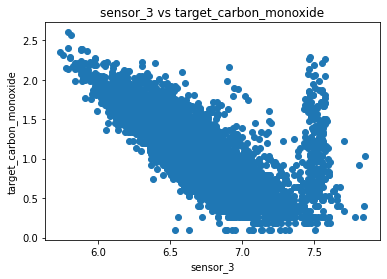

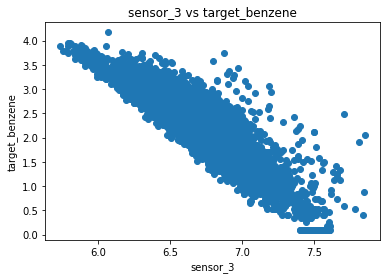

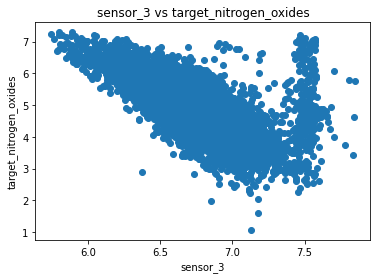

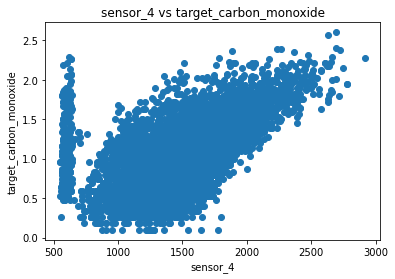

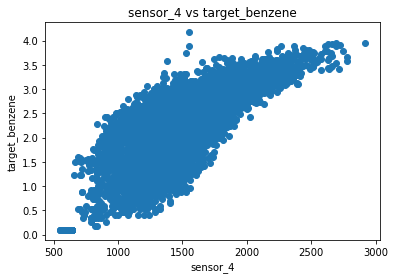

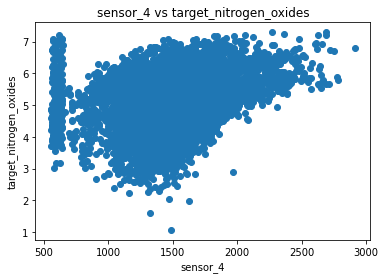

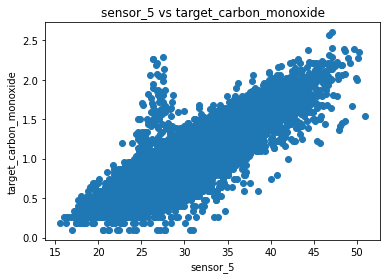

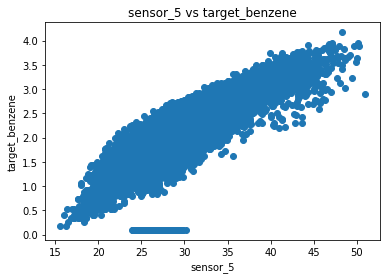

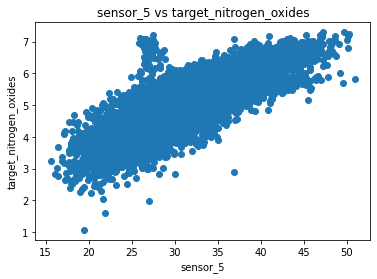

In [25]:
for feature in num_features:
    for target in targets:
        plt.scatter(train_data[feature], train_data[target])
        plt.title('{} vs {}'.format(feature, target))
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.show()

# Feature Engineering

In [26]:
train_df = pd.read_csv('train.csv')

print(train_df.shape)
train_df.head()

(7111, 12)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


## Target Variables

In [27]:
for target in targets:
    train_df[target] = np.log1p(train_df[target])

## TimeStamp Data

In [28]:
date_time = np.array(train_df['date_time']).astype(str)

for i in range(len(date_time)):
    date_time[i] = np.where(date_time[i][-8] == '0', date_time[i][-7], date_time[i][-8:-6])

date_time = (date_time).astype(int)

In [29]:
train_df['hour'] = date_time
train_df.drop(['date_time'], axis = 1, inplace = True)

In [30]:
train_df['cat1'] = np.where(train_df['hour'].isin(np.arange(5, 9)), 1, 0)
train_df['cat2'] = np.where(train_df['hour'].isin(np.arange(9, 16)), 1, 0)
train_df['cat3'] = np.where(train_df['hour'].isin(np.arange(16, 20)), 1, 0)
train_df['cat4'] = np.where(train_df['hour'].isin([20, 21, 22, 23, 0, 1, 2, 3, 4]), 1, 0)

In [31]:
train_df.drop('hour', axis = 1, inplace = True)

## Numerical Features

In [32]:
for feature in right_skewed:
    train_df[feature] = np.log(train_df[feature])

train_df['sensor_5'] = train_df['sensor_5'] ** 0.5

In [33]:
train_df.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,cat1,cat2,cat3,cat4
0,13.1,46.0,0.7578,7.235043,6.991913,6.962243,1742.8,35.963871,1.252763,2.564949,5.128122,0,0,1,0
1,13.2,45.3,0.7255,7.153912,6.789197,7.087991,1449.9,31.794654,1.131402,2.388763,4.604170,0,0,1,0
2,12.6,56.2,0.7502,7.194362,6.834754,6.966213,1586.1,33.421550,1.163151,2.322388,4.852811,0,0,0,1
3,11.0,62.4,0.7867,7.186144,6.834109,7.005698,1536.5,35.541525,1.163151,2.370244,5.182907,0,0,0,1
4,11.9,59.0,0.7888,7.148346,6.748408,7.074032,1415.5,33.648180,0.916291,2.001480,4.810557,0,0,0,1


In [34]:
train_df.to_csv('processed_data2.csv', index = False)

# Feature Selection

In [35]:
train_data = pd.read_csv('processed_data2.csv')

X = train_data.drop(targets, axis = 1)
y = train_data[targets]

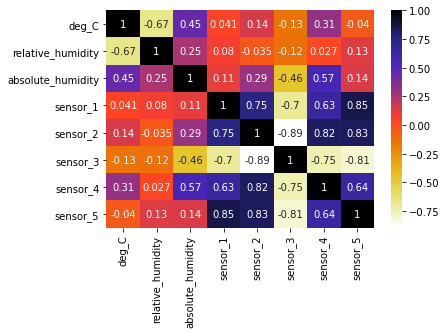

In [36]:
cor = X.iloc[:, :-4].corr()

sns.heatmap(cor, annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420)

In [38]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [39]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test Data

In [40]:
test_data = pd.read_csv('test.csv')

In [41]:
test_df = test_data.copy()

print(test_df.shape)
test_df.head()

(2247, 9)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [42]:
date_time = np.array(test_df['date_time']).astype(str)

for i in range(len(date_time)):
    date_time[i] = np.where(date_time[i][-8] == '0', date_time[i][-7], date_time[i][-8:-6])

date_time = (date_time).astype(int)

In [43]:
test_df['hour'] = date_time
test_df.drop(['date_time'], axis = 1, inplace = True)

In [44]:
test_df['cat1'] = np.where(test_df['hour'].isin(np.arange(5, 9)), 1, 0)
test_df['cat2'] = np.where(test_df['hour'].isin(np.arange(9, 16)), 1, 0)
test_df['cat3'] = np.where(test_df['hour'].isin(np.arange(16, 20)), 1, 0)
test_df['cat4'] = np.where(test_df['hour'].isin([20, 21, 22, 23, 0, 1, 2, 3, 4]), 1, 0)

In [45]:
test_df.drop('hour', axis = 1, inplace = True)

In [46]:
for feature in right_skewed:
    test_df[feature] = np.log(test_df[feature])

test_df['sensor_5'] = test_df['sensor_5'] ** 0.5

In [47]:
test_df.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,cat1,cat2,cat3,cat4
0,8.0,41.3,0.4375,7.011034,6.614323,6.680980,880.0,35.680527,0,0,0,1
1,5.1,51.7,0.4564,7.130499,6.762614,6.533643,972.8,41.400483,0,0,0,1
2,5.8,51.5,0.4689,7.005426,6.777647,6.542040,941.9,36.066605,0,0,0,1
3,5.0,52.3,0.4693,7.038520,6.820235,6.586999,1011.0,35.818989,0,0,0,1
4,4.5,57.5,0.4650,6.929908,6.731615,6.770216,967.0,33.797929,0,0,0,1


In [48]:
test_scaled = scaler.transform(test_df)

In [49]:
test_result = pd.DataFrame(data = test_data['date_time'], columns = ['date_time'])

# ANN Model

In [50]:
def build_model(hp):
    model = Sequential([
        Dense(units = hp.Int('dense_1_units', min_value = 32, max_value = 128, step = 16),
              activation = 'relu',
              kernel_initializer = hp.Choice('dense_1_kernel', values = ['he_uniform', 'he_normal']),
              input_dim = 12),
        Dense(units = hp.Int('dense_2_units', min_value = 32, max_value = 64, step = 16),
              activation = 'relu',
              kernel_initializer = hp.Choice('dense_2_kernel', values = ['he_uniform', 'he_normal'])),
        Dense(units = hp.Int('dense_3_units', min_value = 32, max_value = 64, step = 16),
              activation = 'relu',
              kernel_initializer = hp.Choice('dense_3_kernel', values = ['he_uniform', 'he_normal'])),
        Dense(units = 1,
              activation = 'relu',
              kernel_initializer = 'normal'),
    ])
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])),
                  loss = 'mean_squared_error',
                  metrics = ['RootMeanSquaredError'])
    return model

## Target1

In [51]:
tuner = RandomSearch(build_model, objective = Objective("val_root_mean_squared_error", direction="min"), max_trials = 10, directory = 'ann_output_target1', project_name = 'Target1')

In [52]:
tuner.search(X_train_scaled, y_train.iloc[:, 0], epochs = 3, validation_split = 0.1)

Trial 10 Complete [00h 00m 02s]
val_root_mean_squared_error: 0.13687582314014435

Best val_root_mean_squared_error So Far: 0.12255330383777618
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


In [53]:
model = tuner.get_best_models(num_models = 1)[0]

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3888      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train_scaled, y_train.iloc[:, 0], epochs = 10, verbose = 1, initial_epoch = 3)

Epoch 4/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440
Epoch 5/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447
Epoch 6/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0196 - root_mean_squared_error: 0.1402
Epoch 7/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467
Epoch 8/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381
Epoch 9/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381
Epoch 10/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387


In [56]:
predictions_1 = model.predict(X_test_scaled)

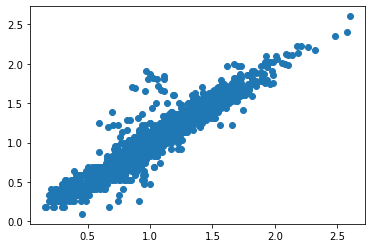

In [57]:
plt.scatter(predictions_1, y_test.iloc[:, 0])
plt.show()

In [58]:
test_result['{}'.format(targets[0])] = np.expm1(model.predict(test_scaled))

## Target2

In [59]:
tuner = RandomSearch(build_model, objective = Objective("val_root_mean_squared_error", direction="min"), max_trials = 10, directory = 'ann_output_target2', project_name = 'Target2')

In [60]:
tuner.search(X_train_scaled, y_train.iloc[:, 1], epochs = 3, validation_split = 0.1)

Trial 10 Complete [00h 00m 02s]
val_root_mean_squared_error: 0.12399720400571823

Best val_root_mean_squared_error So Far: 0.09966135770082474
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


In [61]:
model = tuner.get_best_models(num_models = 1)[0]

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                1248      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3104      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 5,985
Trainable params: 5,985
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(X_train_scaled, y_train.iloc[:, 1], epochs = 10, verbose = 1, initial_epoch = 3)

Epoch 4/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108
Epoch 5/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137
Epoch 6/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031
Epoch 7/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103
Epoch 8/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145
Epoch 9/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118
Epoch 10/10
178/178 [==============================] - 1s 4ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088


In [64]:
predictions_2 = model.predict(X_test_scaled)

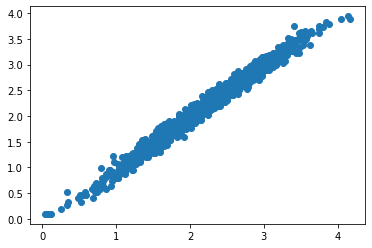

In [65]:
plt.scatter(predictions_2, y_test.iloc[:, 1])
plt.show()

In [66]:
test_result['{}'.format(targets[1])] = np.expm1(model.predict(test_scaled))

## Target 3

In [67]:
tuner = RandomSearch(build_model, objective = Objective("val_root_mean_squared_error", direction="min"), max_trials = 10, directory = 'ann_output_target3', project_name = 'Target3')

In [68]:
tuner.search(X_train_scaled, y_train.iloc[:, 2], epochs = 3, validation_split = 0.1)

Trial 10 Complete [00h 00m 02s]
val_root_mean_squared_error: 0.4009054899215698

Best val_root_mean_squared_error So Far: 0.35662704706192017
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


In [69]:
model = tuner.get_best_models(num_models = 1)[0]

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 112)               1456      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                5424      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,081
Trainable params: 10,081
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(X_train_scaled, y_train.iloc[:, 2], epochs = 10, verbose = 1, initial_epoch = 3)

Epoch 4/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
Epoch 5/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1636 - root_mean_squared_error: 0.4045
Epoch 6/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1550 - root_mean_squared_error: 0.3937
Epoch 7/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1432 - root_mean_squared_error: 0.3784
Epoch 8/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1311 - root_mean_squared_error: 0.3620
Epoch 9/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1345 - root_mean_squared_error: 0.3667
Epoch 10/10
178/178 [==============================] - 1s 4ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755


In [72]:
predictions_3 = model.predict(X_test_scaled)

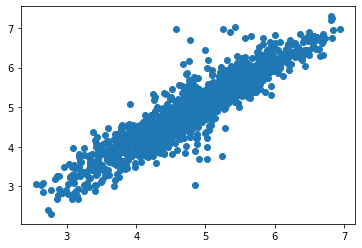

In [73]:
plt.scatter(predictions_3, y_test.iloc[:, 2])
plt.show()

In [74]:
test_result['{}'.format(targets[2])] = np.expm1(model.predict(test_scaled))

# Test Result

In [75]:
test_result.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.389566,5.392435,224.761978
1,2011-01-01 01:00:00,2.002002,8.131639,353.011505
2,2011-01-01 02:00:00,1.774842,7.779842,360.058502
3,2011-01-01 03:00:00,1.976569,8.339364,326.348755
4,2011-01-01 04:00:00,1.398247,6.554370,221.480515
